Haim Zisman, 204410005  
Ori Malka, 315150599

# Pre-requirements & Definitions

## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import statsmodels
from scipy import stats

import warnings # removing sns style warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt

## Constants

In [ ]:
# CONSTANTS
ID = 'id'
LABEL = 'diagnosis'
MALIGNANT_VALUE = 'M'
BENIGN_VALUE = 'B'
MALIGNANT_NAME = 'Malignant'
BENIGN_NAME = 'Benign'
PALETTE = 'coolwarm'
SEED = 0

# Visualization Hyperparameters
TITLE_FONT_SIZE = 12
PLOT_TEXT_SIZE = 11
NUM_COLUMNS = 5

# Label Occurences
FIGURE_SIZE = (6, 4)

# Corr Matrix
CORR_FIGURE_SIZE = (18, 10)
VALUE_FORMATING = ".2f"
CORR_PALETTE = "ch:s=-.2,r=.6"

# Box plots
coolwarm_palette = sns.color_palette("coolwarm", n_colors=2)
BOX_PALETTE = {BENIGN_VALUE: coolwarm_palette[0], MALIGNANT_VALUE: coolwarm_palette[-1]}
WHISKER_LEN = 2.
BOX_PLOT_FIGURE_SIZE = (15, 5)

# KDE
WIDTH_PER_SUBPLOT = HEIGHT_PER_SUBPLOT = 5
LOG_SCALED = False
BENIGN_COLOR = 'blue'
MALIGNANT_COLOR = 'red'

# Outliers DIST
COLOR = 'skyblue'
ALPHA = 0.6

# Training
TEST_PORTION = 0.1
METRIC_FP_PRECISION = 3
XGBOOST_MODEL_OBJECTIVE = 'binary:logistic'
METRIC_CRITERIA = 'recall'
NUM_KFOLD = 10
NUM_ITER = 10 # Default
CLASSIFER_THRESHOLD = 0.5

## Metrics Definition

In [ ]:
metrics_dict = {
    'logloss': lambda labels, preds: log_loss(labels, preds),
    'accuracy': lambda labels, preds: accuracy_score(labels, preds),
    'precision': lambda labels, preds: precision_score(labels, preds, zero_division=1),
    'recall': lambda labels, preds: recall_score(labels, preds, zero_division=1),
    'f1': lambda labels, preds: f1_score(labels, preds, zero_division=1),
}

## Downloading dataset

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1n7_H-ZXhkx85GgehXk539rZZ3BZ_KCNE
!gdown --id 1253WoDDfscgrr0_4DYd4RZSA4zMpCbTL

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1n7_H-ZXhkx85GgehXk539rZZ3BZ_KCNE
To: /content/breast-cancer.csv
100% 125k/125k [00:00<00:00, 63.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1253WoDDfscgrr0_4DYd4RZSA4zMpCbTL
To: /content/TabularDS_project.ipynb
100% 1.18M/1.18M [00:00<00:00, 87.3MB/s]


In [ ]:
file_path = '/content/breast-cancer.csv'
df = pd.read_csv(file_path)

# Dataset Analysis

The Breast Cancer Dataset contains measurements derived from breast cancer x-rays.   
Each entry includes features such as the radius, texture, and area of tumor cells, which are taken from multiple observations or parts of the tumor.  

Therefore, every feature is an aggregation of statistical parameters such as mean, standard error, and maximum (often referred to as "worst").

## Data Structure

dataset columns

In [ ]:
df_dtypes = pd.DataFrame(df.dtypes).reset_index()
df_dtypes.columns = ['Column', 'Data Type']
print(df_dtypes)

                     Column Data Type
0                        id     int64
1                 diagnosis    object
2               radius_mean   float64
3              texture_mean   float64
4            perimeter_mean   float64
5                 area_mean   float64
6           smoothness_mean   float64
7          compactness_mean   float64
8            concavity_mean   float64
9       concave points_mean   float64
10            symmetry_mean   float64
11   fractal_dimension_mean   float64
12                radius_se   float64
13               texture_se   float64
14             perimeter_se   float64
15                  area_se   float64
16            smoothness_se   float64
17           compactness_se   float64
18             concavity_se   float64
19        concave points_se   float64
20              symmetry_se   float64
21     fractal_dimension_se   float64
22             radius_worst   float64
23            texture_worst   float64
24          perimeter_worst   float64
25          

Our data consists of numeric measurements [floating-point numbers]

In [ ]:
non_numeric_cols = [ID, LABEL]
numerical_df = df.drop(non_numeric_cols, axis=1)

In [ ]:
f"Number of Samples: {numerical_df.shape[0]}"

'Number of Samples: 569'

## Data Distribution Description

In [ ]:
numerical_df.describe().drop('count', axis=0).T

,mean,std,min,25%,50%,75%,max
radius_mean,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


#### Observations


---


1. Data range variability, like in `area_worst` (185.2 to 4254.0) and `area_mean` (143.5 to 2501.0), suggests potential outliers and the need for normalization.

2. Outliers: Significant difference between the Q3 and max value (or min value and Q1) suggest outliers' existence.  
Examples:
  - `concavity_worst` Q3=0.38, max=1.25
  - `area_worst` Q3=1084.0, max=4254.0
  - `area_se` Q3=45.2, max=542.2
  - `perimeter_se` Q3=3.35, max=21.98
  - `area_mean` Q3=782.7, max=2501.0


---


Alignment with Related Works & Datasets:  
Actual Dataset source: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic  

Upon reviewing related works, the distribution appears reliable and originates from the source dataset. However, it's unclear whether the skewed values are due to measurement errors.


## Quantitative Measure of Skewness

In [ ]:
skewness_rate_df = numerical_df.skew().sort_values(ascending=False)
skewness_rate_df

area_se                    5.447186
concavity_se               5.110463
fractal_dimension_se       3.923969
perimeter_se               3.443615
radius_se                  3.088612
smoothness_se              2.314450
symmetry_se                2.195133
compactness_se             1.902221
area_worst                 1.859373
fractal_dimension_worst    1.662579
texture_se                 1.646444
area_mean                  1.645732
compactness_worst          1.473555
concave points_se          1.444678
symmetry_worst             1.433928
concavity_mean             1.401180
fractal_dimension_mean     1.304489
compactness_mean           1.190123
concave points_mean        1.171180
concavity_worst            1.150237
perimeter_worst            1.128164
radius_worst               1.103115
perimeter_mean             0.990650
radius_mean                0.942380
symmetry_mean              0.725609
texture_mean               0.650450
texture_worst              0.498321
concave points_worst       0

All features are right-skewed in different scales, especially standard error measurements. Further Outliers & Skewness investigation is needed.

## Data Quality and Nullness

In [ ]:
numerical_df.isnull().sum()

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Based on the null counts provided for the dataset, it can be concluded that there are no missing values across all features listed.

# Prediction Problem Definition

### The objective

Predicting the diagnosis of breast tissues as either malignant (M) or benign (B). This task involves utilizing a comprehensive set of diagnostic measurements.

### The Criteria metric - Recall

It is crucial to accurately identify as many true positives as possible to ensure that individuals with cancer receive the necessary treatment.   Concurrently, maintaining a high true negative rate is important to prevent misdiagnosing healthy individuals, thereby safeguarding them from receiving unnecessary and potentially harmful treatments.

# Data Visualizations

### Label Occurences

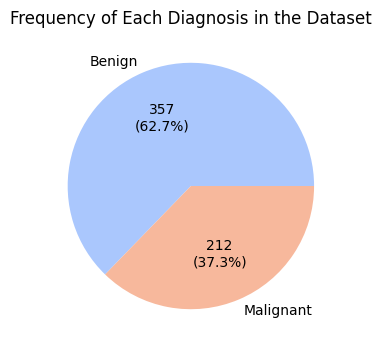

In [ ]:
full_names = {MALIGNANT_VALUE: MALIGNANT_NAME, BENIGN_VALUE: BENIGN_NAME}
label_counts = df[LABEL].value_counts().rename(index=full_names)

plt.figure(figsize=FIGURE_SIZE)
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p), colors=sns.color_palette(PALETTE, len(label_counts)))
plt.title('Frequency of Each Diagnosis in the Dataset', fontsize=TITLE_FONT_SIZE)
plt.show()

 An imbalance between the two classes, with benign cases being more common than malignant.

### Pair-wise Pearson Correlation Heatmap

In [ ]:
numerical_df[LABEL] = df[LABEL].apply(lambda y: (float)(y == MALIGNANT_VALUE))

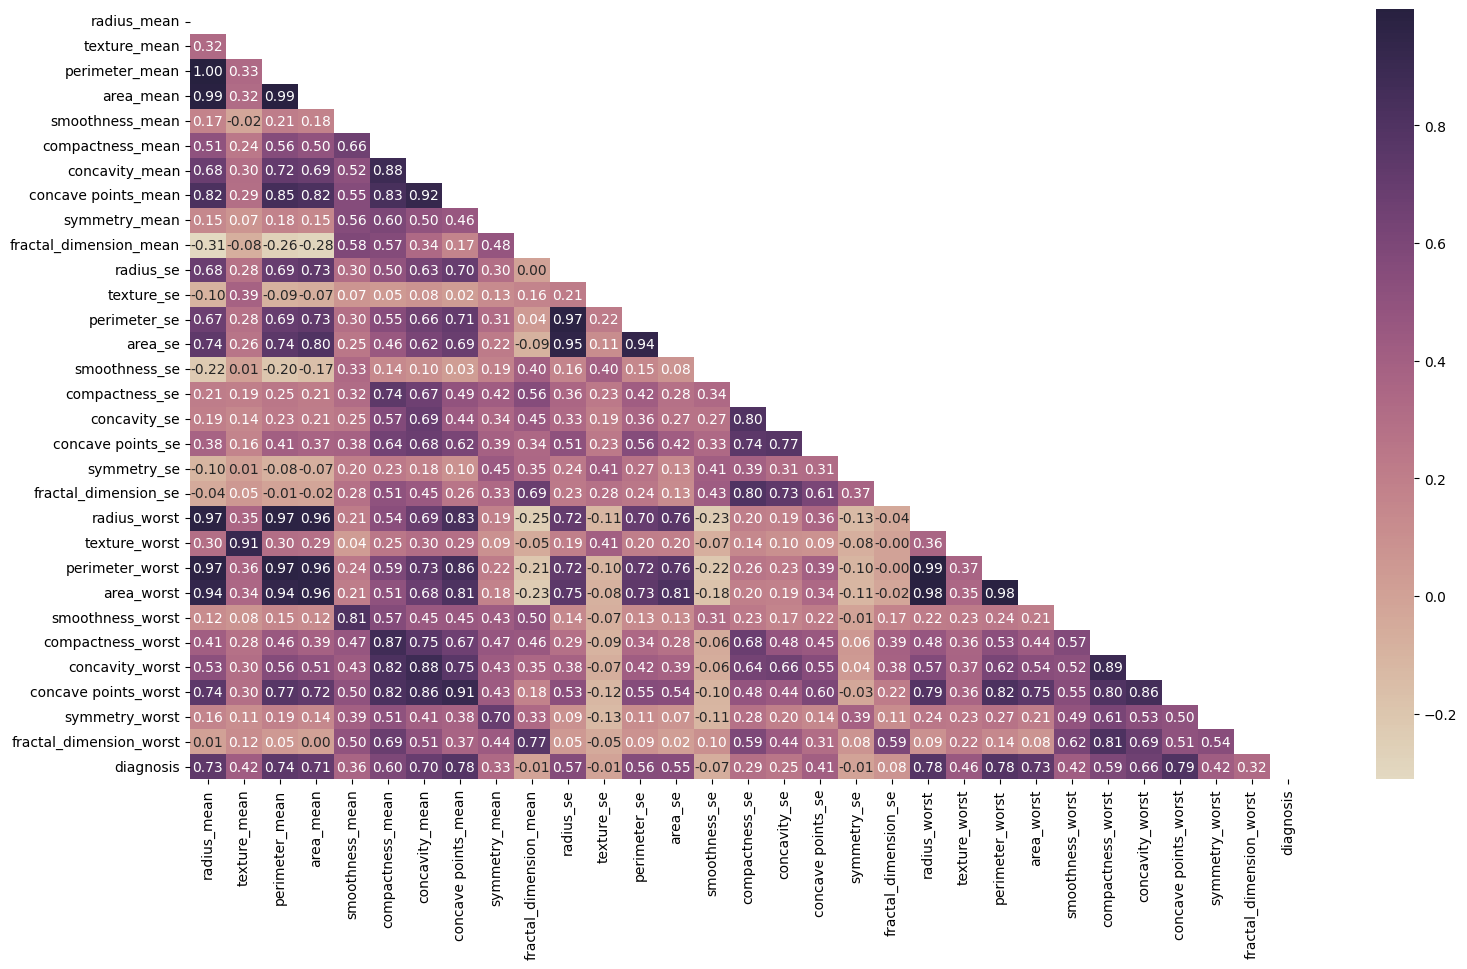

In [ ]:
corr = numerical_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=CORR_FIGURE_SIZE)
sns.heatmap(corr, mask=mask, cmap=sns.color_palette(CORR_PALETTE, as_cmap=True), annot=True, fmt=VALUE_FORMATING)
plt.show()


#### Observations


---


1. **Key Predictors**: `radius_mean`, `perimeter_mean`, `area_mean`,
   `concavity_mean`, `concave points_mean`, and `concave points_worst`
   have significant correlations with diagnosis, showing their
   importance for the predictive model.

2. **Redundant Features and Multicollinearity**: Strong correlations
   among size-related features (`radius_mean`, `perimeter_mean`,
   `area_mean`) and shape descriptors (`compactness_mean`,
   `compactness_worst`, `concavity_mean`, `concavity_worst`,
   `concave points_mean`, `concave points_worst`) indicate
   multicollinearity. This suggests these features provide overlapping
   information, making it possible to reduce them to streamline the
   model without compromising its predictive power.

3. **Weak Correlations**: Features like `fractal_dimension_mean` and
   specific `texture_se` and `symmetry_se` metrics exhibit minimal
   correlation with diagnosis, making them potential candidates for
   exclusion to simplify the model and possibly enhance performance.


---



### Identifying Outliers Across TOP10 Skewed Distributions (Boxplot)

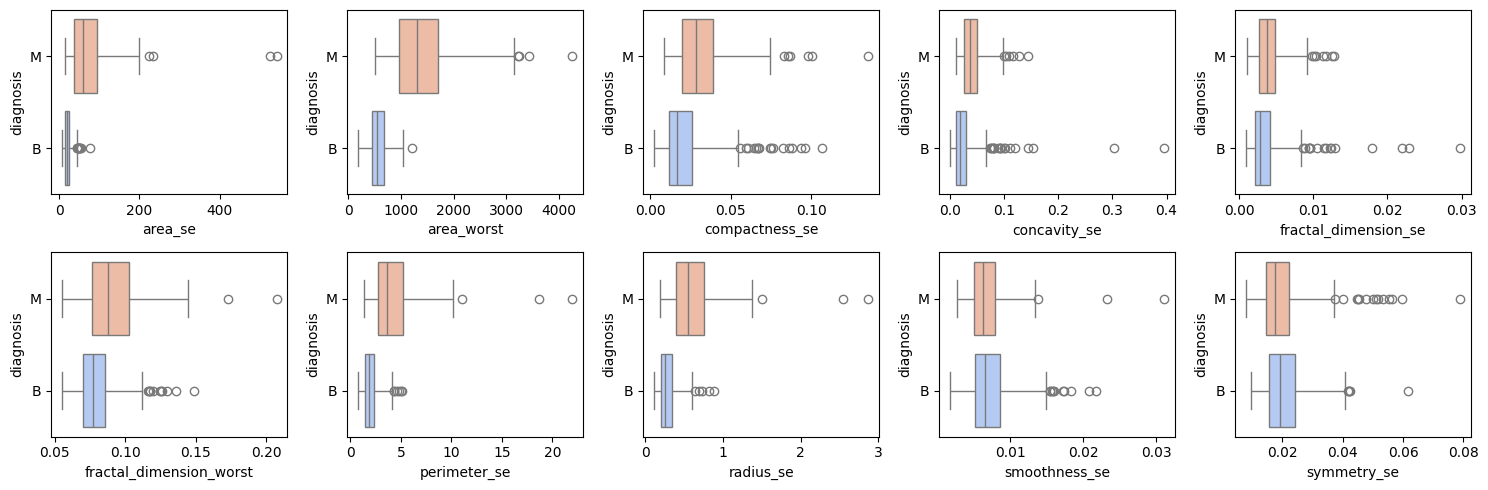

In [ ]:
features_lexico_sorted = sorted(numerical_df.drop(LABEL, axis=1).columns)
top_10_skewed_features = skewness_rate_df.nlargest(10).index.tolist()
features_filtered = [feature for feature in features_lexico_sorted if feature in top_10_skewed_features]

num_features = len(features_filtered)
num_rows = num_features // NUM_COLUMNS + (1 if num_features % NUM_COLUMNS > 0 else 0)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, NUM_COLUMNS, figsize=BOX_PLOT_FIGURE_SIZE)

for i, feature in enumerate(features_filtered):
    row, col = divmod(i, NUM_COLUMNS)
    sns.boxplot(y=LABEL, x=feature, data=df, ax=axes[row, col], whis=WHISKER_LEN, palette=BOX_PALETTE)

# Hide any unused subplots
for j in range(i + 1, num_rows * NUM_COLUMNS):
    axes.flat[j].set_visible(False)

plt.tight_layout()
plt.show()


#### Observations


---


Outliers Reinforcing Distinction

(Area_worst, Perimeter_se, Area_se, Radius_se):  
- Outliers emphasize the existing trend of much higher values in Malignant cases, aiding in the distinction without negatively impacting it.

Outliers Adding Noise

(Fractal_dimension_se, Fractal_dimension_worst, Smoothness_se, Symmetry_se, Compactness_se):  
- Outliers mix with both diagnoses, adding noise and complicating classification.

(Concavity_se):  
- While it generally indicates malignancy with higher values, outliers do not distinctly enhance or weaken the separation between diagnoses, but adds some small effect.


---



#### Hypothesis: Same Outlier Data Points

Due to the high correlation (collinearity) among many skewed features, it is highly likely that outliers in one feature are also outliers in another correlated feature. For instance, it makes sense for `Area_se` and `Area_worst` to share outliers, as a large area might also result in significant size variability (standard error) across different measurements.

### Comparative Kernel Density Estimation: Top 5 & Bottom 5 Correlated Features for Benign vs. Malignant

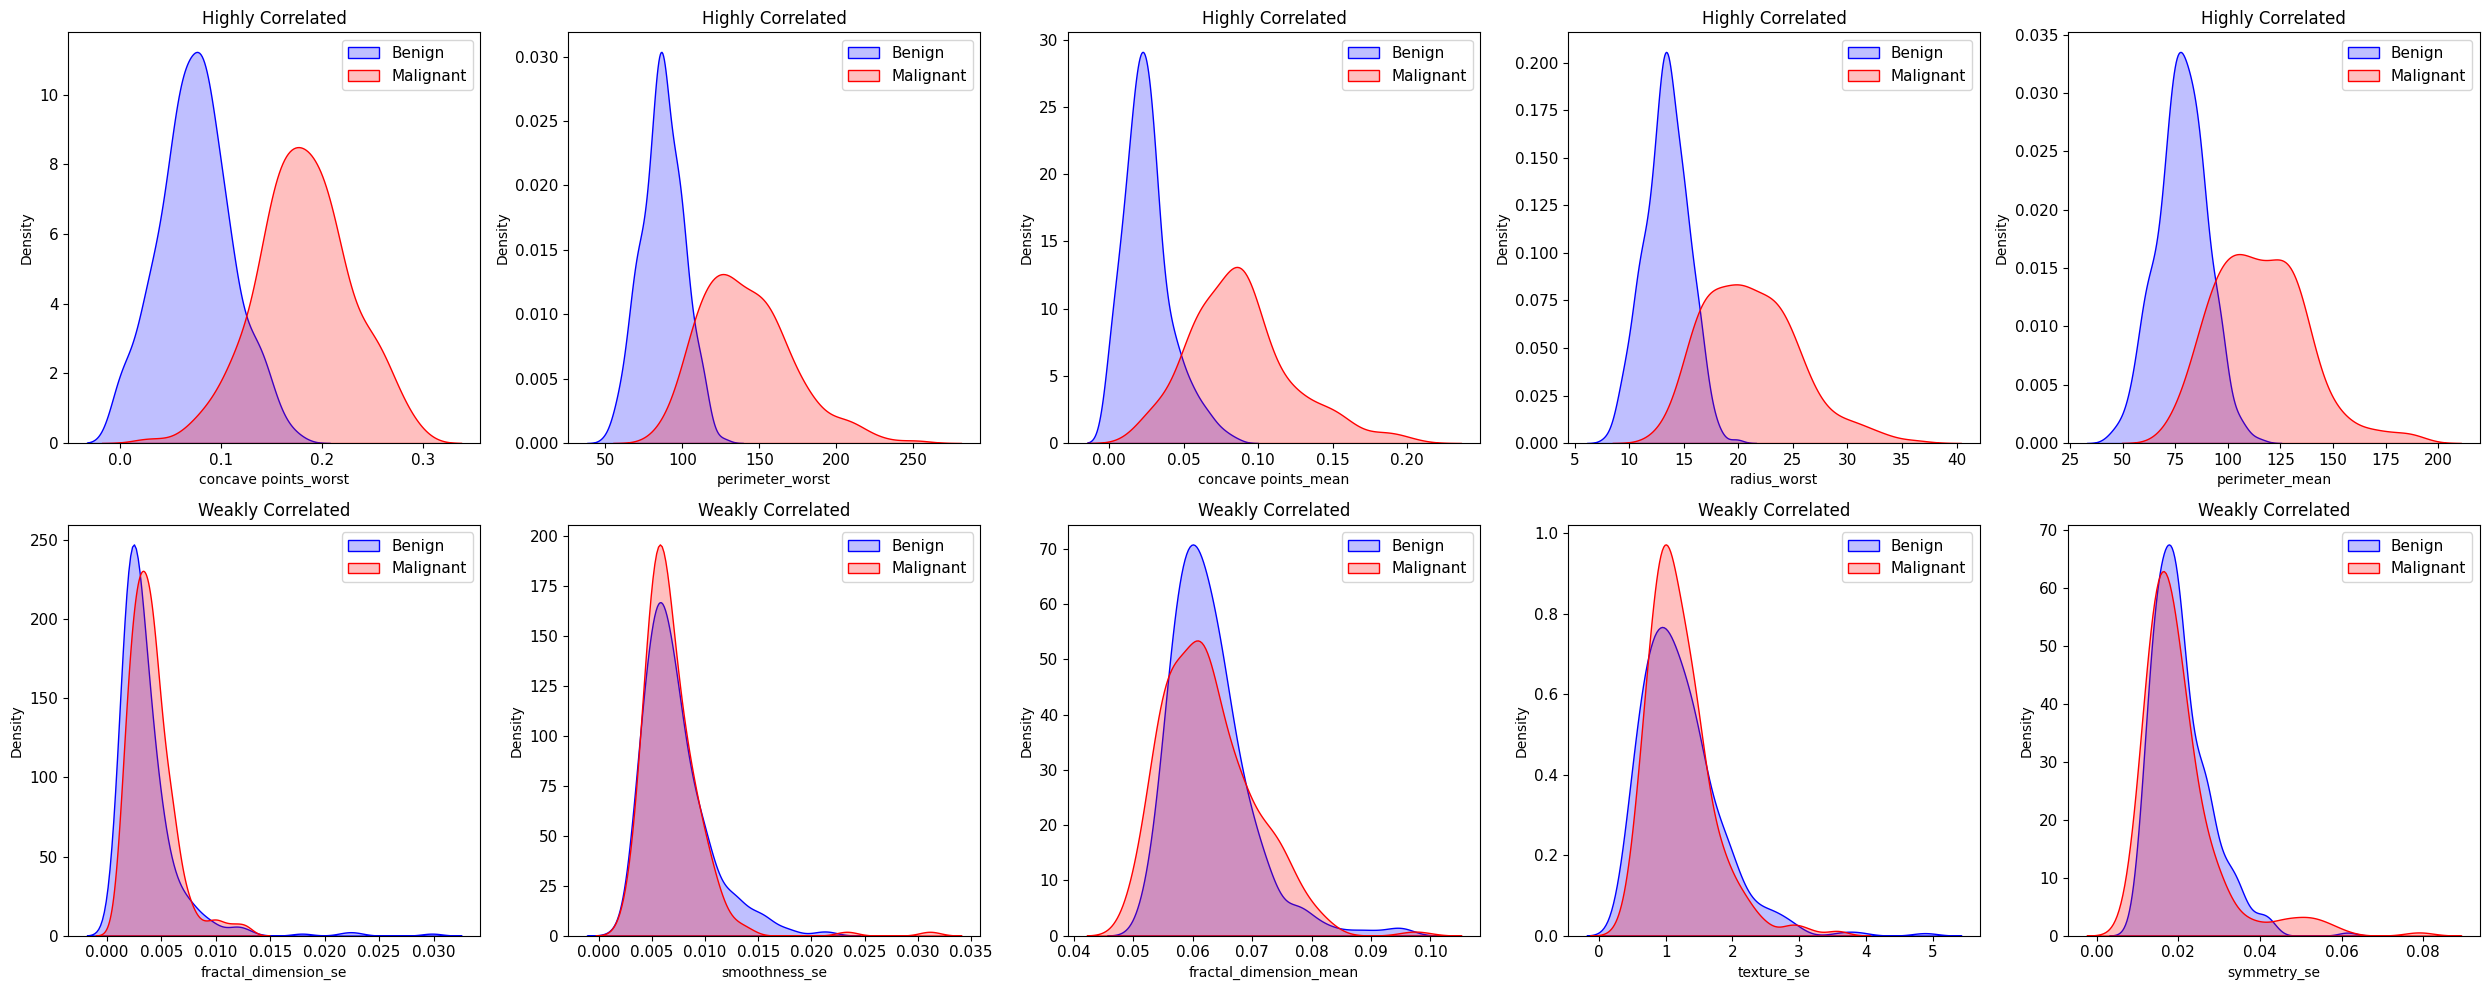

In [ ]:
correlations = corr[LABEL].drop(LABEL).abs().sort_values(ascending=False)
top_features = correlations.head(NUM_COLUMNS).index.tolist() + correlations.tail(NUM_COLUMNS).index.tolist()

num_rows = (len(top_features) // NUM_COLUMNS + (1 if len(top_features) % NUM_COLUMNS else 0))
fig, axes = plt.subplots(num_rows, NUM_COLUMNS, figsize=(WIDTH_PER_SUBPLOT * NUM_COLUMNS, HEIGHT_PER_SUBPLOT * num_rows), squeeze=False)

for index, feature in enumerate(top_features):
    ax = axes[index // NUM_COLUMNS, index % NUM_COLUMNS]
    sns.kdeplot(numerical_df[df[LABEL] == BENIGN_VALUE][feature], ax=ax, label=BENIGN_NAME, shade=True, color=BENIGN_COLOR, log_scale=LOG_SCALED)
    sns.kdeplot(numerical_df[df[LABEL] == MALIGNANT_VALUE][feature], ax=ax, label=MALIGNANT_NAME, shade=True, color=MALIGNANT_COLOR, log_scale=LOG_SCALED)
    ax.set_title(f'{"Highly" if index < NUM_COLUMNS else "Weakly"} Correlated', fontsize=TITLE_FONT_SIZE)
    ax.legend(fontsize=PLOT_TEXT_SIZE)
    ax.tick_params(axis='both', labelsize=PLOT_TEXT_SIZE)

for ax in axes.flat[index + 1:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

#### Observations


---


Correlation & KDE Overlapping:  
- Features with smaller overlaps between the benign and malignant KDE distributions generally show a stronger correlation with the diagnosis, and vice versa.

Highly Correlated Features:  
- The separation between benign and malignant distributions in `concave points_worst/mean`, `perimeter_worst/mean` and `radius_worst` features indicates these are strong predictors of malignancy.

Weakly Correlated Features:  
- Overlapping densities in `fractal dimension_se/mean`, `smoothness_se`, `texture_se`, and `symmetry_se` metrics suggest they have low discriminatory power.  
- Removing features with the most overlapping distributions, such as `fractal_dimension_se`, can reduce noise and simplify the model.
- We can see that most of the weakly has strong right tail, log transform can considered.


---



### Collecting & Visualizing the Distribution of Outliers in the Dataset
Our goal is to identify outlier data points (with `id`)  from previous visualizations. Given the high correlation among features, it is highly likely that some data points are outliers across multiple features. Understanding this distribution is key to determining our approach to managing outliers.

### Collecting Outliers using configured Whishker and IQR

In [ ]:
outliers_mask = pd.DataFrame(False, index=df[ID], columns=features_lexico_sorted)


def mark_outliers_by_diagnosis_with_id(df, features, whis=2.0):
    # Function to calculate and mark outliers using IQR, preserving sample IDs
    for diagnosis in df[LABEL].unique():
        diagnosis_group = df[df[LABEL] == diagnosis]
        for feature in features:
            Q1 = diagnosis_group[feature].quantile(0.25)
            Q3 = diagnosis_group[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - whis * IQR
            upper_bound = Q3 + whis * IQR

            # Mark outliers in the mask DataFrame, using id col to reference the correct samples
            outliers_indices = diagnosis_group[(diagnosis_group[feature] < lower_bound) | (diagnosis_group[feature] > upper_bound)][ID]
            outliers_mask.loc[outliers_indices, feature] = True

mark_outliers_by_diagnosis_with_id(df, features_lexico_sorted, WHISKER_LEN)
outliers_samples = outliers_mask[outliers_mask.any(axis=1)]
outliers_samples = outliers_samples.reset_index()

### Visualizing Outliers

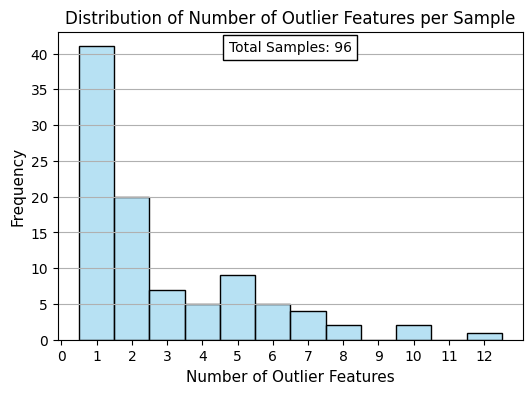

In [ ]:
outlier_counts = outliers_samples.drop(columns=[ID]).sum(axis=1)
plt.figure(figsize=FIGURE_SIZE)

bins = np.arange(outlier_counts.min(), outlier_counts.max() + 2) - 0.5
sns.histplot(outlier_counts, bins=bins, stat='count', color=COLOR, alpha=ALPHA)

total_samples = len(outlier_counts)
plt.text(0.5, 0.95, f'Total Samples: {total_samples}', ha='center', va='center',
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white'))

plt.title('Distribution of Number of Outlier Features per Sample', fontsize=TITLE_FONT_SIZE)
plt.xlabel('Number of Outlier Features', fontsize=PLOT_TEXT_SIZE)
plt.ylabel('Frequency', fontsize=PLOT_TEXT_SIZE)
plt.xticks(range(int(outlier_counts.max()) + 1))
plt.grid(axis='y')
plt.show()


#### Observations


---


Outlier Feature Frequency:  
- The majority of samples exhibit a low number of outliered features.

Implications for Model Robustness:  
- Considerable number of data points has multiple outlier features, it can weaken the reliability of a model. We can evaluate different strategies for handling outliers for these data points.

---



# Model Training - XGBoost

shifting from EDA to XGBoost classifier training with 10-fold cross-validation.

## Data preprocessing

### Standardization (Z-score)

In [ ]:
training_df = numerical_df.drop(LABEL, axis=1).apply(zscore)

feature standartization in order to prevent dominance of certain features during model training.  
[It's less important for XGBoost, as it is less sensitive to feature scales, but it might be helpful if we use regularization techniques]

### Prepare the data

In [ ]:
def data_preprocess(training_df=training_df, df=df, test_size=TEST_PORTION, random_state=SEED):
    X = training_df.values
    encoder = LabelEncoder()
    y = encoder.fit_transform(df[LABEL])
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    dtest = xgb.DMatrix(X_test)

    return X_train, X_test, Y_train, Y_test, dtest

In [ ]:
X_train, X_test, Y_train, Y_test, dtest = data_preprocess()

## Training

### Set XGBoost parameters

In [ ]:
def init_xgboost_params(objective=XGBOOST_MODEL_OBJECTIVE, seed=SEED, n_splits=NUM_KFOLD, shuffle=False):
    evals_result = {}
    params = {'objective': objective, 'seed': seed}
    kf = KFold(n_splits=n_splits, shuffle=shuffle)

    return evals_result, params, kf

In [ ]:
evals_result, params, kf = init_xgboost_params()

### Initialize lists to store the fold results

In [ ]:
def init_results_params(metrics_dict):
    models = []
    metrics_summary = {metric_name: [] for metric_name in metrics_dict.keys()}
    best_fold = {'model': None,
                'evals_result': {},
                'metrics': {metric_name: 0.0 for metric_name in metrics_dict.keys()}}

    return models, metrics_summary, best_fold

In [ ]:
models, metrics_summary, best_fold = init_results_params(metrics_dict)

### XGBoost Evaluation Callback Function

XGBoost only provides average metrics across all folds during cross-validation, hiding specific fold trends like overfitting. Our Callback Function evaluates custom metrics per fold to uncover these trends.


In [ ]:
def eval_metrics(preds, data):
    labels = data.get_label()
    preds_binary = (preds > CLASSIFER_THRESHOLD).astype(int)

    metrics_results = []
    for metric_name, func in metrics_dict.items():
      if metric_name != 'logloss': # xgb already handles this metric
        metrics_results.append((metric_name, func(labels, preds_binary)))
    return metrics_results

### Test Set Evaluation for XGBoost

Evaluates an XGBoost model on the test set, updating metrics and the best fold based on criteria. It calculates and compares metrics, updating if the current model outperforms the best fold according to these criteria.

Parameters:
- bst: The booster model.  
- metrics_summary: Stores metric values.  
- best_fold: Contains the best model's details.  


In [ ]:
def eval_on_test(bst):
    pred_probs = bst.predict(dtest)
    pred_labels = (pred_probs > CLASSIFER_THRESHOLD).astype(int)

    # Calculate and update metrics in a generic manner
    for metric_name, func in metrics_dict.items():
        metric_value = func(Y_test, pred_labels if metric_name != 'logloss' else pred_probs)
        metrics_summary[metric_name].append(metric_value)

    # Update best_fold metrics with the latest from metrics_summary
    if best_fold['metrics'][METRIC_CRITERIA] < metric_value:
        best_fold['model'] = bst
        best_fold['evals_result'] = evals_result
        for k in metrics_summary:
            best_fold['metrics'][k] = metrics_summary[k][-1]

### Training Loop
This loop facilitates the training and evaluation of 10 XGBoost models through K-Fold cross-validation:

1. Splitting the data per fold into train and validation sets.
2. Converting data into DMatrix format for optimal training efficiency.
3. Training the model with both data sets and employing custom metrics for evaluation.
4. Adding each trained model to a collection for subsequent analysis.
5. Evaluating each model on a test set to update the metrics summary and determine the best model based on predefined criteria.


In [ ]:
def training(X_train, Y_train, params, eval_metrics, evals_result, models, num_iter=NUM_ITER, verbose_eval=False):
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        # Split the training data according to the current fold
        x_train, x_val = X_train[train_index], X_train[val_index]
        y_train, y_val = Y_train[train_index], Y_train[val_index]

        # Convert the training and validation sets into DMatrix format
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dval = xgb.DMatrix(x_val, label=y_val)

        # Train & Evaluate the model
        model = xgb.train(params, dtrain, NUM_ITER, [(dtrain, 'train'), (dval, 'val')],
                        custom_metric=eval_metrics, evals_result=evals_result, verbose_eval=verbose_eval)
        models.append(model)

        # Evaluate the model on the test set
        eval_on_test(model)

In [ ]:
training(X_train, Y_train, params, eval_metrics, evals_result, models)

## Evaluation Metrics and Results

### Plotting Training & Validation Metrics for Best-Fold

Ploting a series of graphs for training and validation metrics over epochs for the best performing fold

#### Parameters:
- evals_results: Contains 'train' and 'val' keys with metric names and epoch values.
- metrics: List of metric names to plot (e.g., 'accuracy', 'loss').


In [ ]:
def plot_metrics_row(evals_results, metrics_names, figsize=(20, 3), lw=2):
    fig, axes = plt.subplots(1, len(metrics_dict), figsize=figsize)
    for ax, metric_name in zip(axes, metrics_names):
        epochs = len(evals_results['train'][metric_name])
        x_axis = range(0, epochs)

        ax.plot(x_axis, evals_results['train'][metric_name], label=f'{metric_name}_train', color='blue', lw=lw)
        ax.plot(x_axis, evals_results['val'][metric_name], label=f'{metric_name}_val', color='orange', lw=lw)

        ax.set_title(f'Best Fold - {metric_name}')
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.tight_layout()
    plt.show()

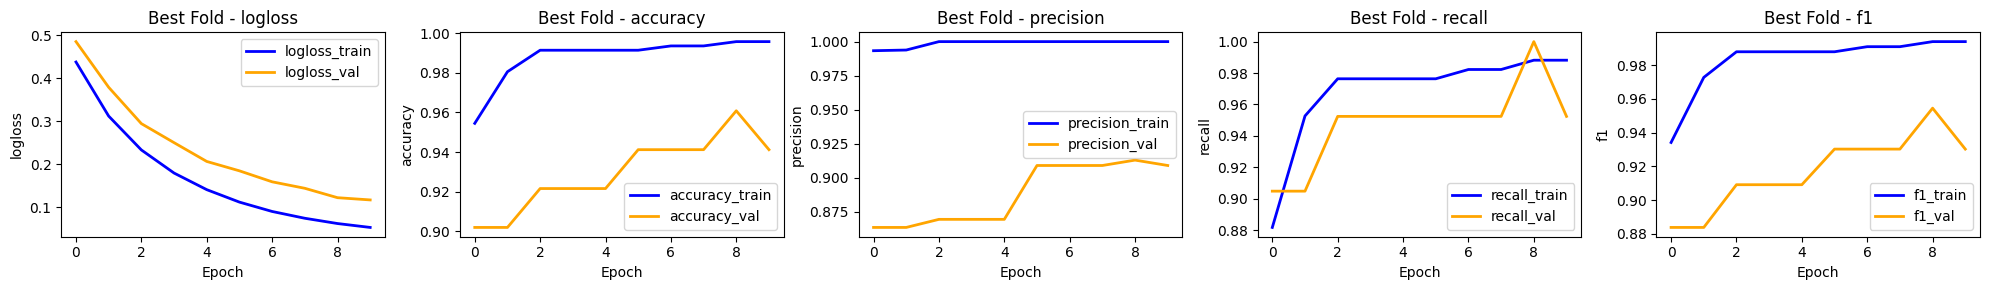

In [ ]:
plot_metrics_row(best_fold['evals_result'], metrics_dict.keys())

#### Observations

---

**Recall (The Criteria):**  
- Recall converges well with training, indicating a good fit and progress in reducing false negatives. An increase in epochs may be beneficial as the graph shows potential for further improvement after 10 epochs.

**Log Loss:**  
- The converging trends between training and validation indicate a well-fitted model.

**Precision:**  
- The precision graph indicates a considerable number of false positives within the chosen fold, which is acceptable given our focus on maximizing recall to minimize false negatives.

---

Overall, the trends suggest that the model is converging appropriately and could benefit from additional epochs.


### Plotting the ROC Curve
Plotting the ROC curve for the best model from cross-validation reveals the trade-off between sensitivity and false-positive rates at various thresholds. By adjusting these thresholds, we can fine-tune the balance between detecting true positives and avoiding false positives, crucial for minimizing false negatives in our predictions.

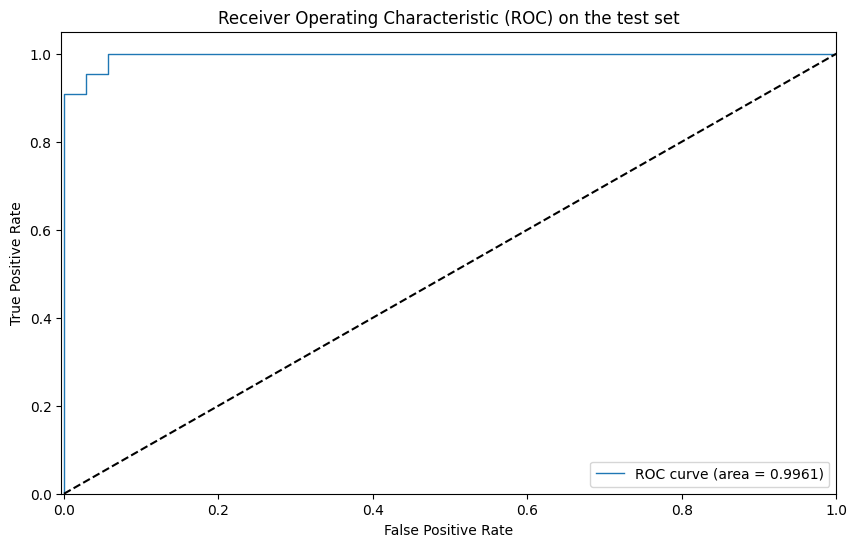

Thresholds: [0.9703649  0.96830785 0.96663475 0.96398634 0.9636972  0.8580964
 0.6736386  0.66709125 0.61970514 0.6125135  0.04445094 0.03719995
 0.02252441 0.02188296 0.0204674 ]
Closest threshold to desired recall: 0.8580964
TPR for that threshold: 0.9090909090909091


In [ ]:
pred_probs = best_fold['model'].predict(dtest)
fpr, tpr, thresholds = roc_curve(Y_test, pred_probs)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc(fpr, tpr), lw=1)
plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([-0.0035, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on the test set')
plt.legend(loc="lower right")
plt.show()

# Print the thresholds
print("Thresholds:", thresholds[1:])

# Desired recall value
desired_recall = 0.9

# Finding the closest threshold for the desired recall
closest_threshold_index = np.argmin(np.abs(tpr - desired_recall))
closest_threshold = thresholds[closest_threshold_index]
closest_tpr = tpr[closest_threshold_index]

print("Closest threshold to desired recall:", closest_threshold)
print("TPR for that threshold:", closest_tpr)

The ROC suggests that the recall is high, indicating that we are correctly identifying a significant proportion of actual positive instances out of all positive instances.

In the next task, we'll try to find the best threshold configuration for our predictive task.

### Summary of all models and best fold performance

Summarizing the results over the test split: average and standard deviation of cross-validation results, both mean and standard deviation from all folds, and from the best one.

In [ ]:
def test(metric_dict, metric_summary):
    rows = []

    # Iterate through each specified metric to process and accumulative results
    for metric in metrics_dict.keys():
        avg = round(np.mean(metrics_summary[metric]), METRIC_FP_PRECISION)
        std = round(np.std(metrics_summary[metric]), METRIC_FP_PRECISION)
        best = round(best_fold['metrics'][metric], METRIC_FP_PRECISION)
        rows.append([metric, avg, std, best])

    df_metrics = pd.DataFrame(rows, columns=['Metric', 'CV_Mean_on_Test', 'CV_STD_on_Test', 'Best_Fold_on_Test'])
    return df_metrics

,Metric,CV_Mean_on_Test,CV_STD_on_Test,Best_Fold_on_Test
0,logloss,0.110,0.020,0.100
1,accuracy,0.956,0.018,0.965
2,precision,0.912,0.028,0.917
3,recall,0.982,0.022,1.000
4,f1,0.945,0.022,0.957


In [ ]:
df_metrics = test(metrics_dict, metrics_summary)
df_metrics

# Administrative Things

## Exporting to PDF

In [ ]:
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf /content/TabularDS_project.ipynb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
[NbConvertApp] Converting notebook /content/TabularDS_project.ipynb to pdf
[NbConvertApp] Support files will be in TabularDS_project_files/
[NbConvertApp] Making directory ./TabularDS_project_files
[NbConvertApp] Making directory ./TabularDS_project_files
[NbConvertApp] Making directory ./TabularDS_project_files
[NbConvertApp] Making directory ./TabularDS_project_files
[NbConvertApp] Making directory ./TabularDS_project_files
[NbConvertApp] Making directory ./TabularDS_project_files
[NbConvertApp] Making directory ./TabularDS_project_files
[NbConvertApp] Writing 91658 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbCo

#